### Connecting to the database on SQL Server.

In [37]:
import pyodbc

conn = pyodbc.connect(
    "DRIVER={ODBC Driver 17 for SQL Server};"
    "SERVER=DESKTOP-JACG8CO\\SQLEXPRESS;"
    "DATABASE=RealEstateAgency;"
    "Trusted_Connection=yes;"
)
print("Connection went successfully!")

Connection went successfully!


In [38]:
import pandas as pd
query = "select table_name from information_schema.tables;"
result = pd.read_sql_query(query, conn)
result

C:\Users\mokha\AppData\Local\Temp\ipykernel_21792\4229557346.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  result = pd.read_sql_query(query, conn)


,table_name
0,Properties
1,Clients
2,Agents
3,Sales
4,Visits
5,sysdiagrams


### Exploring 'Properties' table.

In [39]:
properties = pd.read_sql_query("select * from Properties", conn)
properties.sample(10)

C:\Users\mokha\AppData\Local\Temp\ipykernel_21792\2605173858.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  properties = pd.read_sql_query("select * from Properties", conn)


,PropertyID,PropertyType,Location,Size_sqm,PriceUSD
985,986,Apartment,New York,118,236638
305,306,Villa,Miami,459,168372
399,400,Retail,Los Angeles,253,63311
537,538,Retail,New York,441,584812
911,912,Warehouse,New York,400,185265
643,644,Retail,Miami,312,645135
52,53,Apartment,Houston,177,189472
599,600,Villa,Chicago,264,609154
246,247,Retail,Miami,398,827397
845,846,Office,Miami,479,727071


#### *Data Quality & Structure Checks*

In [40]:
#Check for Missing Values
properties.isnull().sum()

PropertyID      0
PropertyType    0
Location        0
Size_sqm        0
PriceUSD        0
dtype: int64

In [41]:
#Identify Duplicates
properties.duplicated().sum()

0

In [42]:
#Verify Data Types
properties.dtypes

PropertyID       int64
PropertyType    object
Location        object
Size_sqm         int64
PriceUSD         int64
dtype: object

In [43]:
#Inspect Unique Values
print("Available property types:", properties.PropertyType.unique())
print("Locations of properties:", properties.Location.unique())

Available property types: ['Warehouse' 'Villa' 'Retail' 'Apartment' 'Office']
Locations of properties: ['New York' 'Miami' 'Los Angeles' 'Chicago' 'Houston']


#### *Descriptive Statistics*

In [44]:
properties[['Size_sqm', 'PriceUSD']].describe()

,Size_sqm,PriceUSD
count,1000.000000,1000.000000
mean,266.800000,520742.562000
std,128.249803,278213.721261
min,50.000000,51696.000000
25%,158.750000,272553.750000
50%,254.000000,521777.000000
75%,374.500000,760105.250000
max,500.000000,998279.000000


In [45]:
properties['PropertyType'].value_counts()
properties['Location'].value_counts()

Location
New York       206
Miami          205
Los Angeles    198
Houston        198
Chicago        193
Name: count, dtype: int64

#### *Exploratory Visualizations*

c:\Users\mokha\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 0, 'Price in Million USD')

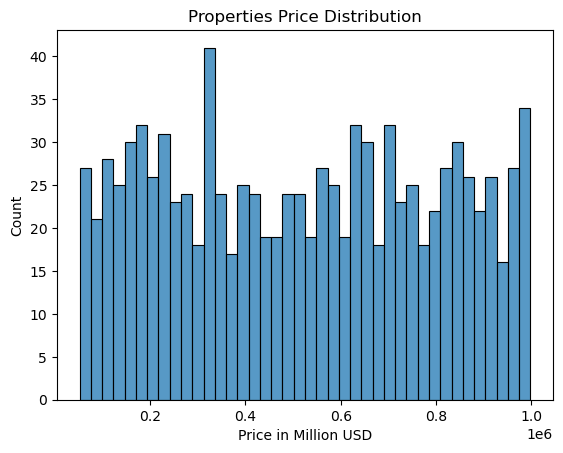

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(properties.PriceUSD, bins=40)
plt.title("Properties Price Distribution")
plt.xlabel("Price in Million USD")

In [47]:
import numpy as np
groupLabels = [200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, np.inf]
groupNames = [
"200K-300K", "300K-400K", "400K-500K", "500K-600K", "600K-700K", "700K-800K", "800K-900K", "900K+"
]
properties['PriceTier'] = pd.cut(
    properties['PriceUSD'],
    bins=groupLabels,
    labels=groupNames,
    right=False
)

stack_data = pd.crosstab(properties['PriceTier'], properties['Location'])
stack_data = stack_data.sort_index(ascending=True)

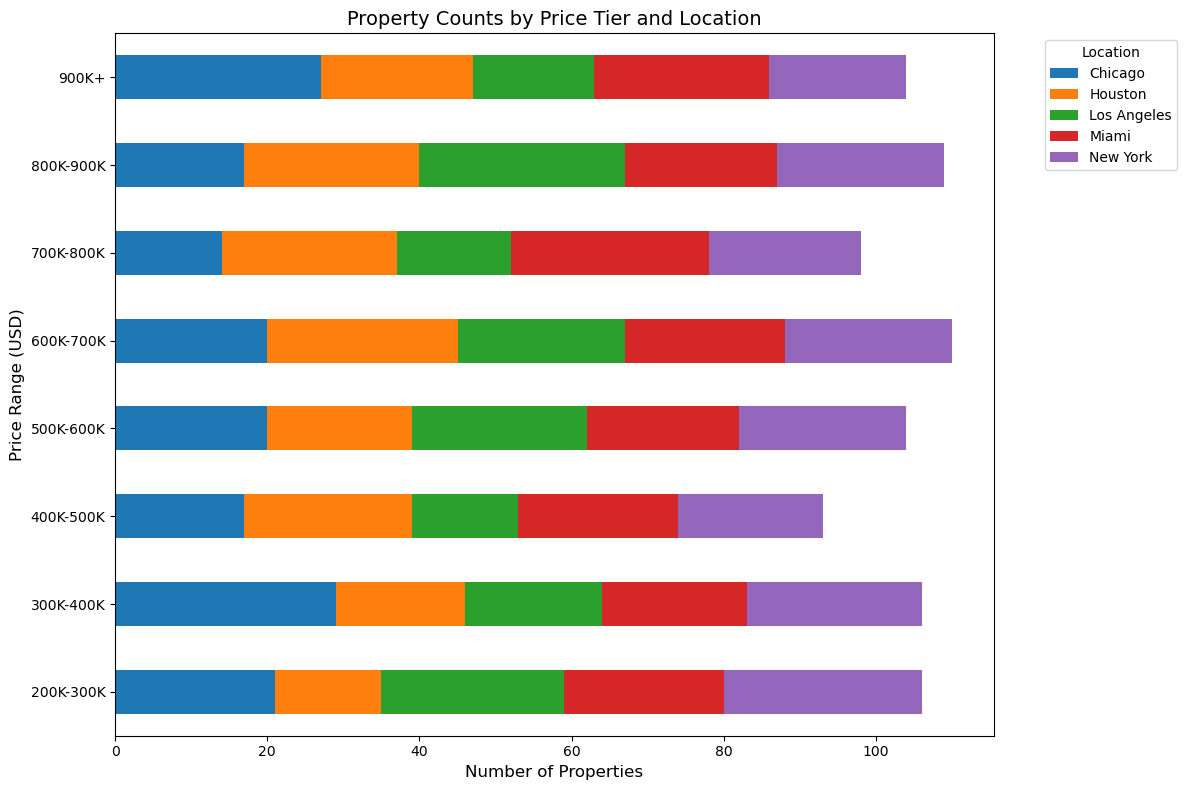

In [48]:
stack_data.plot(
    kind='barh',
    stacked=True,
    figsize=(12, 8),
)

# Customize
plt.title('Property Counts by Price Tier and Location', fontsize=14)
plt.xlabel('Number of Properties', fontsize=12)
plt.ylabel('Price Range (USD)', fontsize=12)
plt.legend(title='Location', bbox_to_anchor=(1.05, 1))  # Move legend outside
plt.tight_layout()
plt.show()

#### *Basic Analysis*

In [49]:
#see the correlation between property size and price
properties[['Size_sqm', 'PriceUSD']].corr()

,Size_sqm,PriceUSD
Size_sqm,1.00000,0.02679
PriceUSD,0.02679,1.00000


In [50]:
#lets see the impact of Location on price per sqm of the property
properties['Price_per_sqm'] = properties['PriceUSD'] / properties['Size_sqm']
sqm_price_per_location = properties.groupby('Location')['Price_per_sqm'].mean().sort_values(ascending=False)
sqm_price_per_location

Location
Chicago        2820.051520
Miami          2725.699262
Houston        2703.518090
New York       2664.552756
Los Angeles    2618.623506
Name: Price_per_sqm, dtype: float64

<Axes: xlabel='PropertyType', ylabel='PriceUSD'>

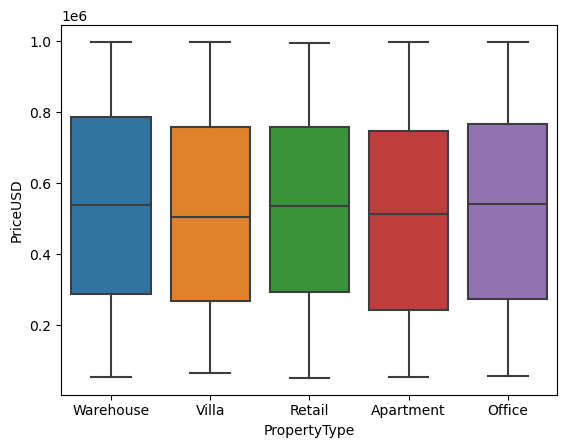

In [51]:
sns.boxplot(data=properties, x='PropertyType', y='PriceUSD')

## Property Market Analysis Summary

- The extremely low correlation (**0.02679**) between `Price` and `Size_sqm` suggests that:  
  - Property prices are **not strongly influenced by size** alone.  
  - Other factors (location, property type, amenities) likely drive pricing more significantly.  

- **Chicago** has the highest mean price per sqm (**$2,820**), followed by **Miami** ($2,726) and **Houston** ($2,704).  
- **Los Angeles** trails despite its high demand, possibly due to larger property sizes diluting the price per sqm.  

- **Mid-range properties (300K-600K)** dominate most locations, especially **Chicago** and **Houston**.  
- **Luxury segments (900K+)** are concentrated in **Miami** and **Los Angeles**, aligning with their premium markets.